<a href="https://colab.research.google.com/github/komorimasashi/bunka-hakaru/blob/main/Py_facemesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MediaPipe Face Mesh Solution API　for Python (http://solutions.mediapipe.dev/face_mesh)　を使って顔の標識点座標を取得します

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.3 MB/s 


PCのカメラを使うための関数

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

PCのカメラで撮影する

<IPython.core.display.Javascript object>

Saved to photo.jpg


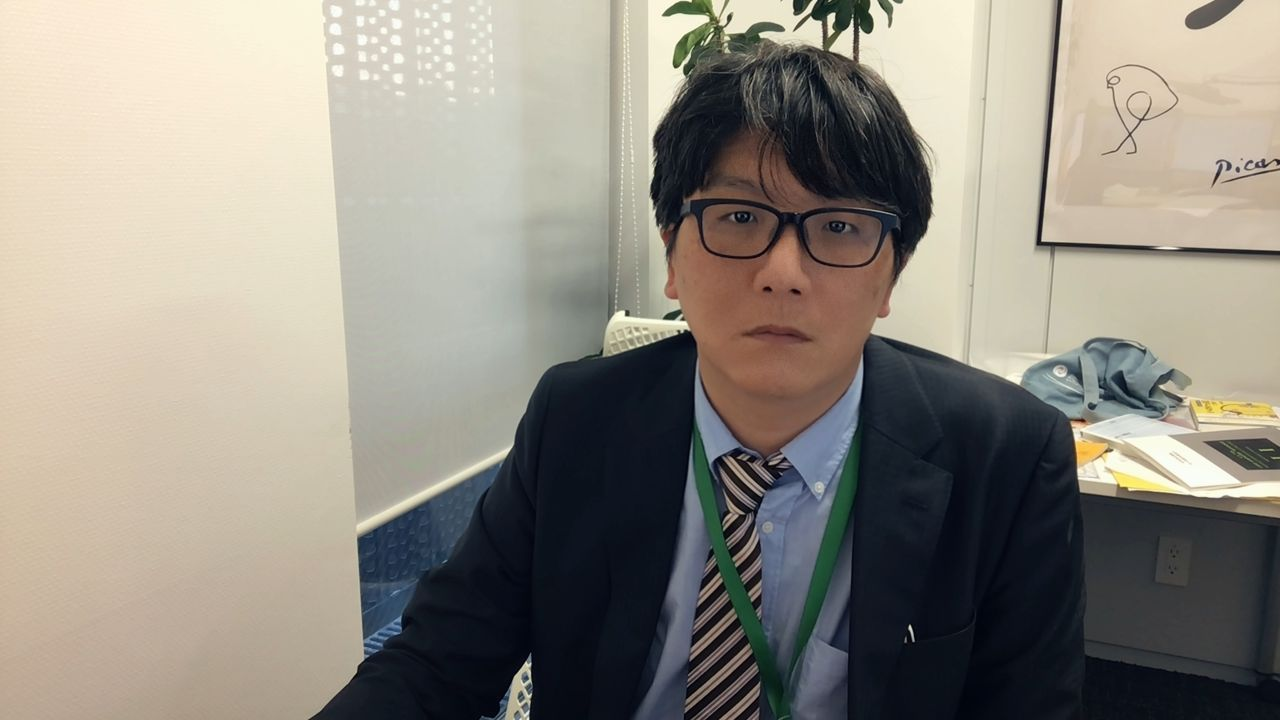

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

カメラで撮った画像をOpenCVで扱います

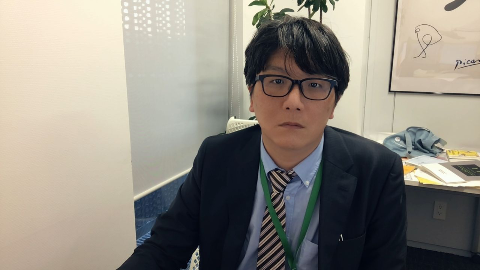

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

# Read images with OpenCV.
image = cv2.imread(filename)

# Preview the images.
resize_and_show(image)

MediaPipeで顔の標識点を認識して表示

In [ ]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh

# help(mp_face_mesh.FaceMesh)

# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

Face landmarks of photo.jpg:


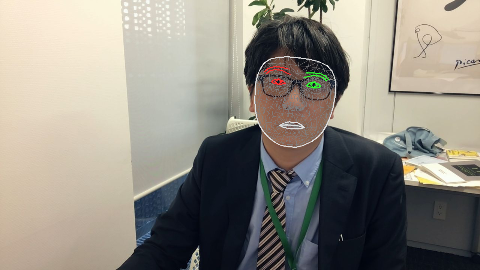

In [ ]:
# Run MediaPipe Face Mesh.
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=2,
    min_detection_confidence=0.5) as face_mesh:

    # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
  results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  # Draw face landmarks of each face.
  print(f'Face landmarks of {filename}:')
 # if not results.multi_face_landmarks:
 #   continue
  annotated_image = image.copy()
  for face_landmarks in results.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_IRISES,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_iris_connections_style())
  resize_and_show(annotated_image)